In [93]:
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import os


In [94]:
# Load data
data = pd.read_csv('pricetest.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume
0,2017-01-03,778.81,789.63,775.80,786.14,"1,657,300"
1,2017-01-04,788.36,791.34,783.16,786.90,"1,073,000"
2,2017-01-05,786.08,794.48,785.02,794.02,"1,335,200"
3,2017-01-06,795.26,807.90,792.20,806.15,"1,640,200"
4,2017-01-09,806.40,809.97,802.83,806.65,"1,272,400"


data pre-processing


In [99]:
def preprocess_stock_data(data, time_steps=10, train_ratio=0.8):
    """
    Preprocess stock data to generate training and testing datasets.
    
    Parameters:
    - data: pandas DataFrame, contains the stock data.
    - time_steps: int, the number of time steps to create sequence data.
    - train_ratio: float, the proportion of the data to be used for training.

    Returns:
    - X_train: np.ndarray, features for the training set.
    - X_test: np.ndarray, features for the testing set.
    - y_train: np.ndarray, labels for the training set.
    - y_test: np.ndarray, labels for the testing set.
    - scaler: MinMaxScaler object, used for inverse transformation.
    """
    # Extract closing prices
    prices = data.loc[:, ["Close"]].values

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(prices)

    # Validate time step length
    if len(scaled_data) <= time_steps:
        raise ValueError(
            f"Input data length ({len(scaled_data)}) is less than the time steps ({time_steps}). "
            "Please increase the data length or reduce the time steps."
        )

    # Create time series sequences
    def create_sequences(data, time_steps):
        X, y = [], []
        for i in range(len(data) - time_steps):
            X.append(data[i:i + time_steps])
            y.append(data[i + time_steps])
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_data, time_steps)

    # Split into training and testing sets
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

# Test function
def test_preprocess_stock_data():
    """
    Test the preprocess_stock_data function.
    """
    # Load test data
    data = pd.read_csv('pricetest.csv')
    X_train, X_test, y_train, y_test, scaler = preprocess_stock_data(
        data,
        time_steps=10,
        train_ratio=0.8
    )

    print("Preprocessing test successful!")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

# If the script is being run directly, execute the test code
if __name__ == "__main__":
    test_preprocess_stock_data()



Preprocessing test successful!
X_train shape: (8, 10, 1)
X_test shape: (2, 10, 1)
y_train shape: (8, 1)
y_test shape: (2, 1)


RNN Model


Training with Learning Rate: 0.0001
LR: 0.0001, Epoch [10/200], Loss: 0.2454
LR: 0.0001, Epoch [20/200], Loss: 0.1218
LR: 0.0001, Epoch [30/200], Loss: 0.0978
LR: 0.0001, Epoch [40/200], Loss: 0.0916
LR: 0.0001, Epoch [50/200], Loss: 0.0921
LR: 0.0001, Epoch [60/200], Loss: 0.0904
LR: 0.0001, Epoch [70/200], Loss: 0.0903
LR: 0.0001, Epoch [80/200], Loss: 0.0899
LR: 0.0001, Epoch [90/200], Loss: 0.0896
LR: 0.0001, Epoch [100/200], Loss: 0.0893
LR: 0.0001, Epoch [110/200], Loss: 0.0890
LR: 0.0001, Epoch [120/200], Loss: 0.0887
LR: 0.0001, Epoch [130/200], Loss: 0.0884
LR: 0.0001, Epoch [140/200], Loss: 0.0880
LR: 0.0001, Epoch [150/200], Loss: 0.0876
LR: 0.0001, Epoch [160/200], Loss: 0.0872
LR: 0.0001, Epoch [170/200], Loss: 0.0868
LR: 0.0001, Epoch [180/200], Loss: 0.0863
LR: 0.0001, Epoch [190/200], Loss: 0.0858
LR: 0.0001, Epoch [200/200], Loss: 0.0852

Training with Learning Rate: 0.001
LR: 0.001, Epoch [10/200], Loss: 0.0950
LR: 0.001, Epoch [20/200], Loss: 0.0872
LR: 0.001, Epoch

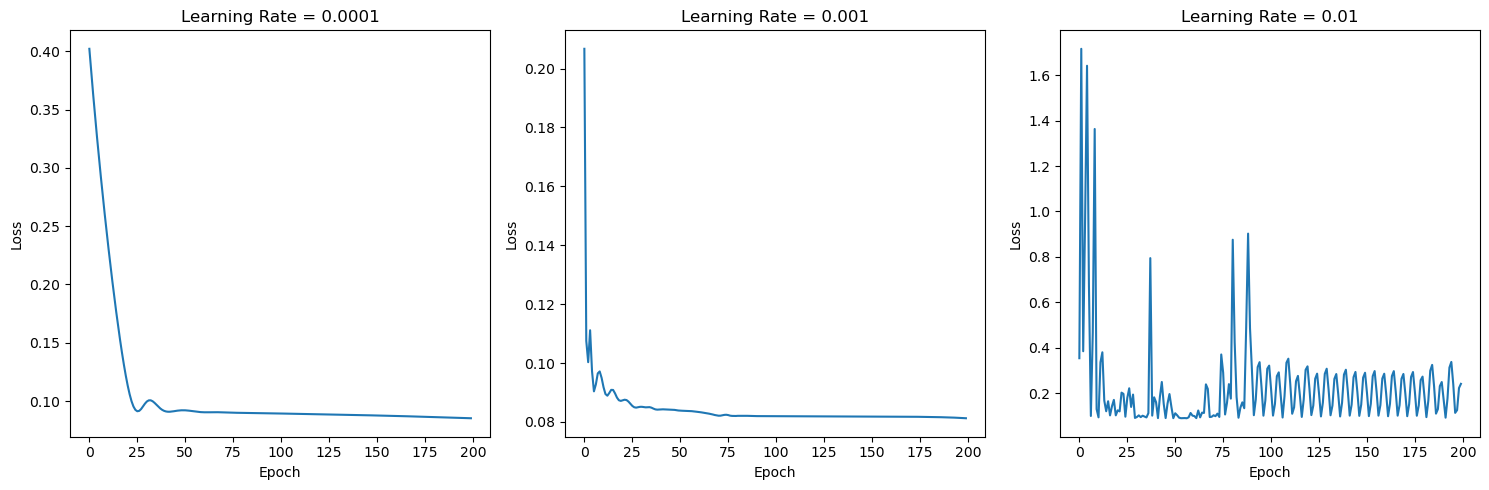


Best Learning Rate: 0.001
RNN Prediction Statistics:
Highest Price: 753.02
Lowest Price: 718.80
Average Price: 745.30

30 Days Close Prices:
Day 1: 753.02
Day 2: 731.35
Day 3: 718.80
Day 4: 746.90
Day 5: 735.45
Day 6: 741.75
Day 7: 749.19
Day 8: 744.00
Day 9: 752.26
Day 10: 745.74
Day 11: 749.60
Day 12: 752.97
Day 13: 747.21
Day 14: 748.77
Day 15: 745.57
Day 16: 745.70
Day 17: 746.63
Day 18: 744.43
Day 19: 746.39
Day 20: 745.91
Day 21: 745.90
Day 22: 746.78
Day 23: 746.26
Day 24: 747.29
Day 25: 747.06
Day 26: 746.81
Day 27: 747.12
Day 28: 746.64
Day 29: 746.81
Day 30: 746.63


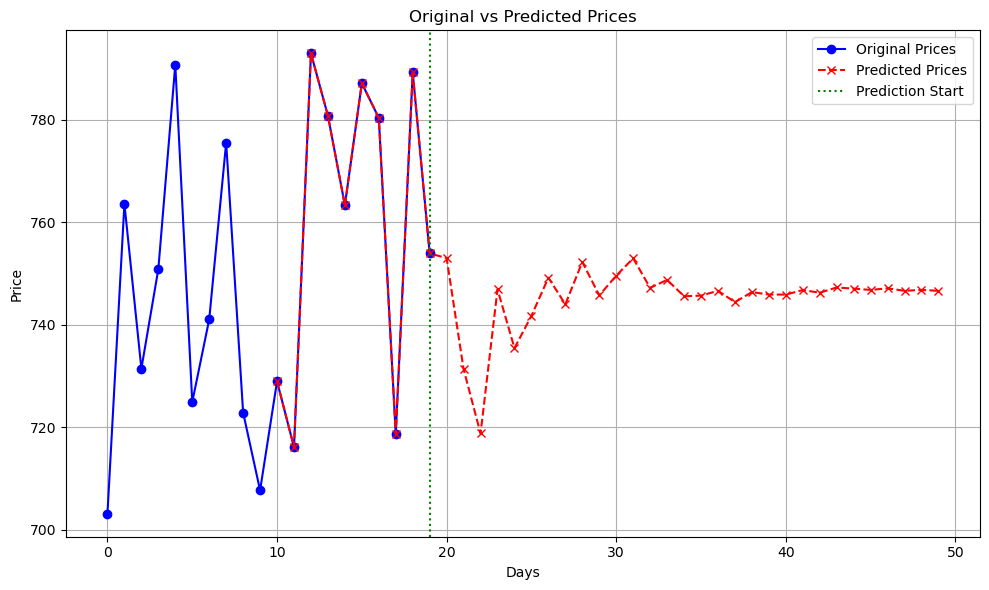

In [103]:
class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

def train_rnn_model(X_train, y_train, learning_rate=0.001, num_epochs=200):
    model = StockRNN(input_size=1, hidden_size=128, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)

    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()

        train_losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"LR: {learning_rate}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    return model, train_losses

def compare_learning_rates(X_train, y_train):
    learning_rates = [0.0001, 0.001, 0.01]
    plt.figure(figsize=(15, 5))

    results = {}
    for i, lr in enumerate(learning_rates, 1):
        print(f"\nTraining with Learning Rate: {lr}")
        model, losses = train_rnn_model(X_train, y_train, learning_rate=lr)
        
        results[lr] = {
            'model': model,
            'losses': losses
        }
        
        plt.subplot(1, 3, i)
        plt.plot(losses)
        plt.title(f'Learning Rate = {lr}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

    # Select the model with the lowest loss
    best_lr = min(results, key=lambda x: results[x]['losses'][-1])
    print(f"\nBest Learning Rate: {best_lr}")
    
    return results[best_lr]['model']

def predict_future_prices(model, initial_sequence, num_days, scaler):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    last_sequence = initial_sequence.clone().detach().to(device)
    future_predictions = []
    
    with torch.no_grad():
        for _ in range(num_days):
            prediction = model(last_sequence)
            future_predictions.append(prediction.item())
            
            new_input = prediction.view(1, 1, 1)
            last_sequence = torch.cat((last_sequence[:, 1:, :], new_input), dim=1)
    
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)
    
    return future_predictions

def main():
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Simulate stock price data
    prices = np.random.uniform(700, 800, 100)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))
    
    # Prepare training data
    seq_len = 10
    X_train, y_train = [], []
    for i in range(len(scaled_prices) - seq_len):
        X_train.append(scaled_prices[i:i + seq_len])
        y_train.append(scaled_prices[i + seq_len])
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    # Compare learning rates and select the best model
    trained_model = compare_learning_rates(X_train, y_train)
    
    # Simulate test data
    test_prices = np.random.uniform(700, 800, 20)
    scaled_test_prices = scaler.transform(test_prices.reshape(-1, 1))
    X_test = scaled_test_prices[-10:].reshape(1, 10, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    
    # Predict future prices
    num_days_to_predict = 30
    future_predictions_rnn = predict_future_prices(trained_model, X_test, num_days_to_predict, scaler)
    
    # Create the complete data sequence
    predicted_full_sequence = np.concatenate([test_prices[-10:], future_predictions_rnn.flatten()])
    
    # Output prediction statistics
    print("RNN Prediction Statistics:")
    print(f"Highest Price: {np.max(future_predictions_rnn):.2f}")
    print(f"Lowest Price: {np.min(future_predictions_rnn):.2f}")
    print(f"Average Price: {np.mean(future_predictions_rnn):.2f}")
    
    print("\n30 Days Close Prices:")
    for day, price in enumerate(future_predictions_rnn.flatten(), 1):
        print(f"Day {day}: {price:.2f}")
    
    # Plot the time series
    days_original = np.arange(len(test_prices))
    days_predicted = np.arange(len(test_prices) - 10, len(test_prices) - 10 + len(predicted_full_sequence))
    
    plt.figure(figsize=(10, 6))
    plt.plot(days_original, test_prices, label='Original Prices', color='blue', marker='o')
    plt.plot(days_predicted, predicted_full_sequence, label='Predicted Prices', color='red', linestyle='--', marker='x')
    plt.axvline(x=days_original[-1], color='green', linestyle=':', label='Prediction Start')
    plt.title('Original vs Predicted Prices')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

LSTM Model

LR 0.0001, Epoch [20/200], Loss: 0.1913
LR 0.0001, Epoch [40/200], Loss: 0.0976
LR 0.0001, Epoch [60/200], Loss: 0.0885
LR 0.0001, Epoch [80/200], Loss: 0.0900
LR 0.0001, Epoch [100/200], Loss: 0.0862
LR 0.0001, Epoch [120/200], Loss: 0.0890
LR 0.0001, Epoch [140/200], Loss: 0.0880
LR 0.0001, Epoch [160/200], Loss: 0.0892
LR 0.0001, Epoch [180/200], Loss: 0.0893
LR 0.0001, Epoch [200/200], Loss: 0.0860
LR 0.001, Epoch [20/200], Loss: 0.0913
LR 0.001, Epoch [40/200], Loss: 0.0894
LR 0.001, Epoch [60/200], Loss: 0.0900
LR 0.001, Epoch [80/200], Loss: 0.0867
LR 0.001, Epoch [100/200], Loss: 0.0897
LR 0.001, Epoch [120/200], Loss: 0.0896
LR 0.001, Epoch [140/200], Loss: 0.0859
LR 0.001, Epoch [160/200], Loss: 0.0882
LR 0.001, Epoch [180/200], Loss: 0.0884
LR 0.001, Epoch [200/200], Loss: 0.0850
LR 0.01, Epoch [20/200], Loss: 0.0911
LR 0.01, Epoch [40/200], Loss: 0.0924
LR 0.01, Epoch [60/200], Loss: 0.0865
LR 0.01, Epoch [80/200], Loss: 0.0856
LR 0.01, Epoch [100/200], Loss: 0.0889
LR 0.01

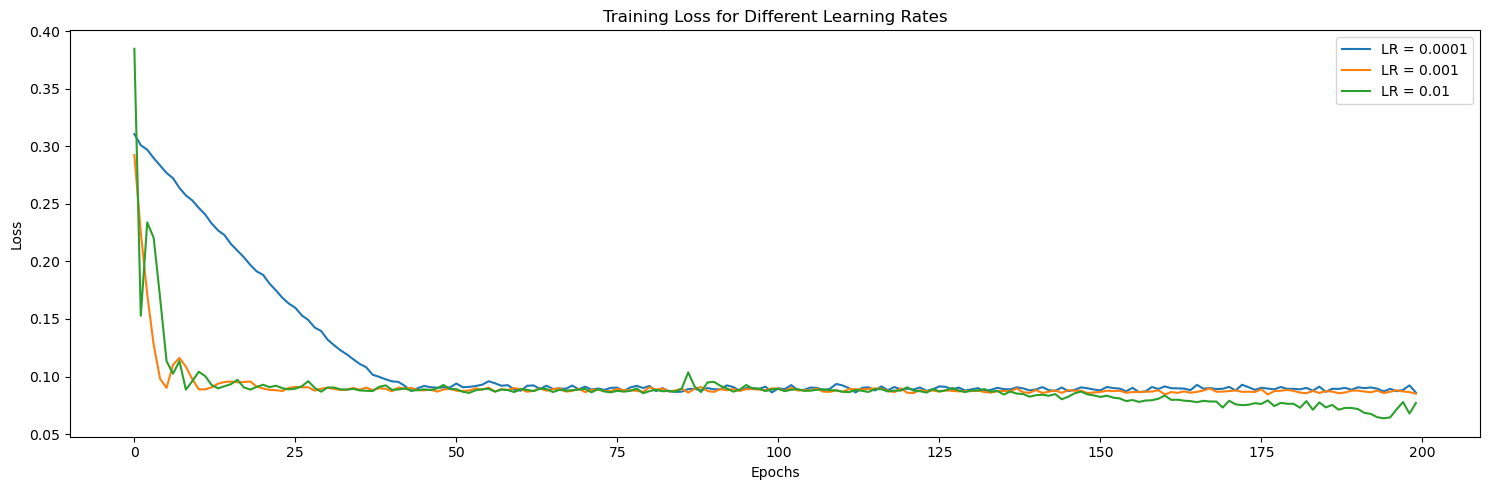

LR 0.0005, Epoch [20/200], Loss: 0.0873
LR 0.0005, Epoch [40/200], Loss: 0.0914
LR 0.0005, Epoch [60/200], Loss: 0.0901
LR 0.0005, Epoch [80/200], Loss: 0.0907
LR 0.0005, Epoch [100/200], Loss: 0.0886
LR 0.0005, Epoch [120/200], Loss: 0.0888
LR 0.0005, Epoch [140/200], Loss: 0.0888
LR 0.0005, Epoch [160/200], Loss: 0.0896
LR 0.0005, Epoch [180/200], Loss: 0.0855
LR 0.0005, Epoch [200/200], Loss: 0.0872


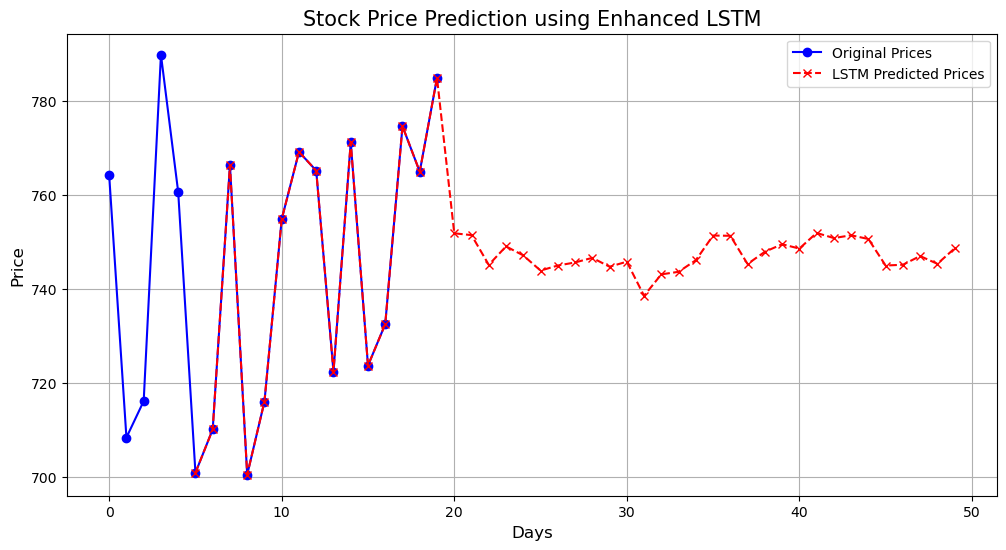


LSTM Prediction Statistics:
Highest Price: 751.94
Lowest Price: 738.57
Average Price: 747.28

30 Days Close Prices:
Day 1: 751.87
Day 2: 751.48
Day 3: 745.16
Day 4: 749.08
Day 5: 747.16
Day 6: 743.94
Day 7: 745.01
Day 8: 745.66
Day 9: 746.64
Day 10: 744.76
Day 11: 745.82
Day 12: 738.57
Day 13: 743.13
Day 14: 743.67
Day 15: 746.14
Day 16: 751.39
Day 17: 751.34
Day 18: 745.34
Day 19: 747.93
Day 20: 749.54
Day 21: 748.62
Day 22: 751.94
Day 23: 750.85
Day 24: 751.44
Day 25: 750.66
Day 26: 745.01
Day 27: 745.17
Day 28: 747.03
Day 29: 745.37
Day 30: 748.66


In [101]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockLSTM, self).__init__()
        # Use bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=0.3, bidirectional=True)
        
        # Adjust fully connected layer to accommodate bidirectional LSTM
        self.fc = nn.Linear(hidden_size * 2, 1)
        
        # Add Dropout layer instead of batch normalization
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # LSTM output
        out, (h_n, c_n) = self.lstm(x)
        
        # Concatenate the last two hidden states (bidirectional LSTM)
        out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        
        # Apply Dropout
        out = self.dropout(out)
        
        # Final prediction
        out = self.fc(out)
        return out

def train_lstm_model(X_train, y_train, learning_rate, num_epochs=200):
    # Create model
    model = StockLSTM(input_size=1, hidden_size=128, num_layers=2)
    
    # Loss function
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
    
    # Device selection
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Loss tracking
    losses = []

    # Training process
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Learning rate decay
        scheduler.step()
        
        # Record loss
        losses.append(loss.item())

        # Print loss every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"LR {learning_rate}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    return model, losses

def compare_learning_rates(X_train, y_train):
    # Different learning rates
    learning_rates = [0.0001, 0.001, 0.01]
    all_losses = {}
    
    # Create plotting area
    plt.figure(figsize=(15, 5))
    
    # Train models with different learning rates
    for lr in learning_rates:
        model, losses = train_lstm_model(X_train, y_train, learning_rate=lr)
        all_losses[lr] = losses
        
        # Plot losses for each learning rate
        plt.plot(losses, label=f'LR = {lr}')
    
    # Customize plot
    plt.title('Training Loss for Different Learning Rates')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return all_losses

def predict_future_prices(model, initial_sequence, num_days, scaler):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    last_sequence = initial_sequence.clone().detach().to(device)
    future_predictions_lstm = []
    daily_close_prices = []

    with torch.no_grad():
        for _ in range(num_days):
            prediction = model(last_sequence)
            prediction_value = prediction.item()
            future_predictions_lstm.append(prediction_value)
            
            # Inverse transform the predicted value
            daily_close = scaler.inverse_transform([[prediction_value]])[0][0]
            daily_close_prices.append(daily_close)
            
            new_input = prediction.view(1, 1, 1)
            last_sequence = torch.cat((last_sequence[:, 1:, :], new_input), dim=1)
    
    future_predictions_lstm = np.array(future_predictions_lstm).reshape(-1, 1)
    future_predictions_lstm = scaler.inverse_transform(future_predictions_lstm)
    
    return future_predictions_lstm, daily_close_prices

def main():
    # Set random seed
    np.random.seed(42)
    torch.manual_seed(42)

    # Simulate price data
    prices = np.random.uniform(700, 800, 200)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))
    
    # Prepare training data
    seq_len = 15
    X_train, y_train = [], []
    for i in range(len(scaled_prices) - seq_len):
        X_train.append(scaled_prices[i:i + seq_len])
        y_train.append(scaled_prices[i + seq_len])
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    # Compare learning rates
    compare_learning_rates(X_train, y_train)
    
    # Prepare test data
    test_prices = np.random.uniform(700, 800, 20)
    scaled_test_prices = scaler.transform(test_prices.reshape(-1, 1))
    X_test = scaled_test_prices[-15:].reshape(1, 15, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    
    # Train final model with best learning rate
    final_model, _ = train_lstm_model(X_train, y_train, learning_rate=0.0005)
    
    # Predict future prices
    num_days_to_predict = 30
    future_predictions_lstm, daily_close_prices = predict_future_prices(final_model, X_test, num_days_to_predict, scaler)
    
    # Create full sequence
    predicted_full_sequence = np.concatenate([test_prices[-15:], future_predictions_lstm.flatten()])
    
    # Create time series for plotting
    days_original = np.arange(len(test_prices))
    days_predicted = np.arange(len(test_prices) - 15, len(test_prices) - 15 + len(predicted_full_sequence))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(days_original, test_prices, label='Original Prices', color='blue', marker='o')
    plt.plot(days_predicted, predicted_full_sequence, label='LSTM Predicted Prices', color='red', linestyle='--', marker='x')
    plt.title('Stock Price Prediction using Enhanced LSTM', fontsize=15)
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print prediction statistics
    print("\nLSTM Prediction Statistics:")
    print("Highest Price: {:.2f}".format(np.max(future_predictions_lstm)))
    print("Lowest Price: {:.2f}".format(np.min(future_predictions_lstm)))
    print("Average Price: {:.2f}".format(np.mean(future_predictions_lstm)))
    
    # Print the final 30 days' close prices
    print("\n30 Days Close Prices:")
    for day, price in enumerate(daily_close_prices, 1):
        print(f"Day {day}: {price:.2f}")

if __name__ == "__main__":
    main()

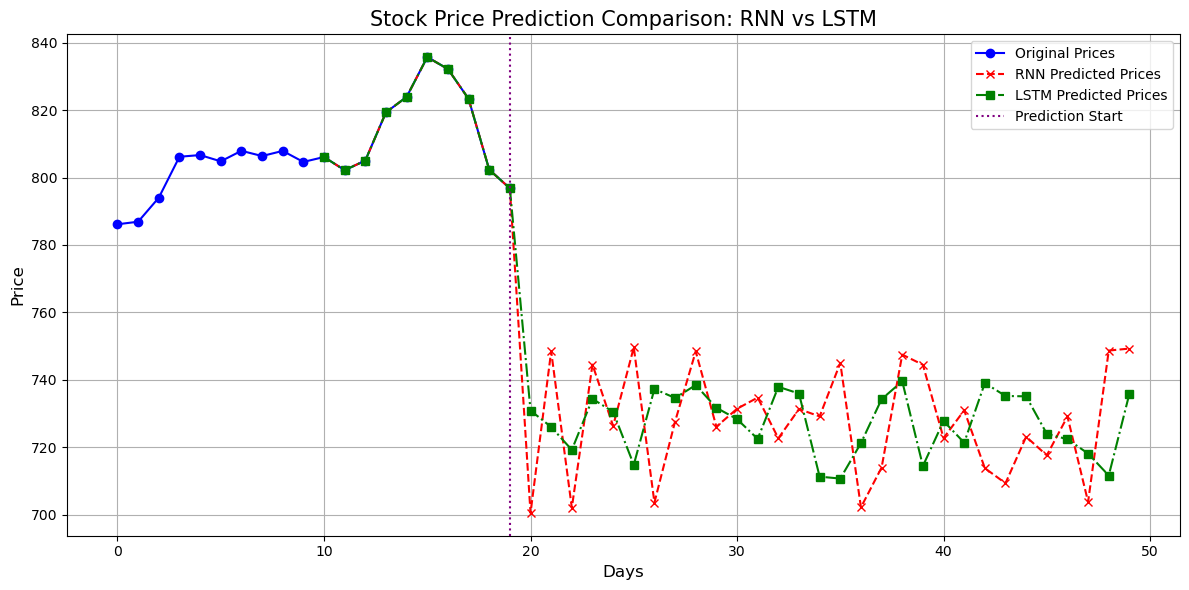

In [102]:
predicted_full_sequence_rnn = np.concatenate([test_prices[-10:], future_predictions_rnn.flatten()])
predicted_full_sequence_lstm = np.concatenate([test_prices[-10:], future_predictions_lstm.flatten()])


days_original = np.arange(len(test_prices))
days_predicted_rnn = np.arange(len(test_prices) - 10, len(test_prices) - 10 + len(predicted_full_sequence_rnn))
days_predicted_lstm = np.arange(len(test_prices) - 10, len(test_prices) - 10 + len(predicted_full_sequence_lstm))


plt.figure(figsize=(12, 6))
plt.plot(days_original, test_prices, label='Original Prices', color='blue', marker='o')
plt.plot(days_predicted_rnn, predicted_full_sequence_rnn, label='RNN Predicted Prices', color='red', linestyle='--', marker='x')
plt.plot(days_predicted_lstm, predicted_full_sequence_lstm, label='LSTM Predicted Prices', color='green', linestyle='-.', marker='s')

plt.axvline(x=days_original[-1], color='purple', linestyle=':', label='Prediction Start')

plt.title('Stock Price Prediction Comparison: RNN vs LSTM', fontsize=15)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
